In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import random
from tqdm import tqdm
import time
import pandas as pd

In [22]:
class BG_Net:
    def __init__(self, dt, cortex, striatum, gpe, snr): ## timestep, neuron number of each layer
        self.dt = dt
        self.cortex = cortex
        self.striatum = striatum
        self.gpe = gpe
        self.snr = snr
        self.E = -65  # Resting potential(mV)
        self.th = -50 # Threshold(mV)
        self.act = 20 # A
        ction potential(mV)
        self.ref = 40 # Refractory period(ms)
        self.rest = 0 # Rest of refractory period(ms)
        self.last = 0 # Last finish time of refractory period(ms)
        self.tau = 15 # Time constant of voltage decay
    
    
    # Run the neural circuit
    def BG_run(self, time, peg): # time:Runtime(ms) of simulation  peg:Pegpattern
        self.time = time
        n0, n1, n2, n3, w0, w1, w2, w3, w4 = self.init_circuit() # n1:ctx, n2:str, n2:gpe, n3:snr, w0:ctx-str w1:str-gpe w2:str-snr w3:gpe-snr w4:snr-ctx
        
        print(w0,w1,w2,w3,w4)
        V_cortex = np.full(self.cortex, self.E)       #Vortage of each neuron
        V_striatum = np.full(self.striatum, self.E)
        V_gpe = np.full(self.gpe, self.E)
        V_snr = np.full(self.snr, self.E)
        
        F_cortex = np.zeros((2,self.cortex))              # Fire or not (1 or 0)
        F_striatum = np.zeros((2,self.striatum))
        F_gpe = np.zeros((2,self.gpe))
        F_snr = np.zeros((2,self.snr))
        
        LS_cortex = np.zeros(self.cortex)              # Time from Last Spike
        LS_striatum = np.zeros(self.striatum)
        LS_gpe = np.zeros(self.gpe)
        LS_snr = np.zeros(self.snr)
        
        V_cortex_log = [[] for i in range(self.cortex)]
        V_striatum_log = [[] for i in range(self.striatum)]
        V_gpe_log = [[] for i in range(self.gpe)]
        V_snr_log = [[] for i in range(self.snr)]

        maskctx = [False for i in range(self.cortex)]
        maskstr = [False for i in range(self.striatum)]
        maskgpe = [False for i in range(self.gpe)]
        masksnr = [False for i in range(self.snr)]
        
        Global_Time = 0
        for t in tqdm(range(self.time)):
            Global_Time = Global_Time + self.dt
   
            V_cortex = V_cortex + np.dot(F_snr[1], w4)*2 + self.Input(Global_Time%4000, n0, peg)*10 + self.Decay(V_cortex, LS_cortex) + [random.randint(1,15) for i in range(self.cortex)]
            for i in range(self.cortex):
                if F_cortex[1][i] == 1:
                    LS_cortex[i] = self.dt
                    F_cortex[0][i] = 0
                    V_cortex[i] = self.E
                    
                elif 0 < LS_cortex[i] < self.ref:
                    LS_cortex[i] = LS_cortex[i] + self.dt
                    V_cortex[i] = self.E
                    
                elif LS_cortex[i] >= self.ref:
                    LS_cortex[i] = 0
                    V_cortex[i] = self.E
                    
                elif V_cortex[i] > self.th:
                    V_cortex[i] = self.act
                    F_cortex[0][i] = 1
                    LS_cortex[i] = self.dt
                else:
                    continue
                    
            
            V_striatum = V_striatum + np.dot(F_cortex[1], w0)*2 + self.Decay(V_striatum, LS_striatum[1]) + [random.randint(1,15) for i in range(self.striatum)]
            for i in range(self.striatum):
                if F_striatum[1][i] == 1:
                    LS_striatum[i] = self.dt
                    F_striatum[0][i] = 0
                    V_striatum[i] = self.E
                    
                elif 0 < LS_striatum[i] < self.ref:
                    LS_striatum[i] = LS_striatum[i] + self.dt
                    V_striatum[i] = self.E
                    
                elif LS_striatum[i] >= self.ref:
                    LS_striatum[i] = 0
                    V_striatum[i] = self.E
                    
                elif V_striatum[i] > self.th:
                    V_striatum[i] = self.act
                    F_striatum[0][i] = 1
                    LS_striatum[i] = self.dt
                    
            V_gpe = V_gpe + np.dot(F_striatum[1], w1)*2 + self.Decay(V_gpe, LS_gpe) + [random.randint(1,20) for i in range(self.gpe)]
            for i in range(self.gpe):
                if F_gpe[1][i] == 1:
                    LS_gpe[i] = self.dt
                    F_gpe[0][i] = 0
                    V_gpe[i] = self.E
                    
                elif 0 < LS_gpe[i] < self.ref:
                    LS_gpe[i] = LS_gpe[i] + self.dt
                    V_gpe[i] = self.E
                    
                elif LS_gpe[i] >= self.ref:
                    LS_gpe[i] = 0
                    V_gpe[i] = self.E
                    
                elif V_gpe[i] > self.th:
                    V_gpe[i] = self.act
                    F_gpe[0][i] = 1
                    LS_gpe[i] = self.dt
                    
            V_snr = V_snr + np.dot(F_striatum[1], w2)*2 + np.dot(F_gpe[1], w3)*10 + self.Decay(V_snr, LS_snr) +  [random.randint(1,17) for i in range(self.snr)]
            for i in range(self.snr):
                if F_snr[1][i] == 1:
                    LS_snr[i] = self.dt
                    F_snr[0][i] = 0
                    V_snr[i] = self.E
                    
                elif 0 < LS_snr[i] < self.ref:
                    LS_snr[i] = LS_snr[i] + self.dt
                    V_snr[i] = self.E
                    
                elif LS_snr[i] >= self.ref:
                    LS_snr[i] = 0
                    V_snr[i] = self.E
                    
                elif V_snr[i] > self.th:
                    V_snr[i] = self.act
                    F_snr[0][i] = 1
                    LS_snr[i] = self.dt
            
            F_cortex[1] = F_cortex[0]
            F_striatum[1] = F_striatum[0]
            F_gpe[1] = F_gpe[0]
            F_snr[1] = F_snr[0]
            
            for i in range(self.cortex):
                V_cortex_log[i] = np.append(V_cortex_log[i], V_cortex[i])
            for i in range(self.striatum):
                V_striatum_log[i] = np.append(V_striatum_log[i], V_striatum[i])
            for i in range(self.gpe):
                V_gpe_log[i] = np.append(V_gpe_log[i], V_gpe[i])
            for i in range(self.snr):
                V_snr_log[i] = np.append(V_snr_log[i], V_snr[i])
            
        
        return V_cortex_log, V_striatum_log, V_gpe_log, V_snr_log
    
    
    ## initiate neural circuit
    def init_circuit(self):
        cortex_feature = np.zeros((self.cortex, 2)) #0 Phase(0~0.9)  #1 Right or Left hemisphere
        for i in range(self.cortex):
            cortex_feature[i][0] = random.randint(0,9)*0.1   # Phase
            cortex_feature[i][1] = random.randint(0,1)       # 0:Right  1:Left

        striatum_feature = np.zeros((self.striatum, 5))        # 0:Phase(ipsi)  1:Phase(contra)  2:R or L  3:D1 or D2  4:resonant(200~400ms)
        for i in range(self.striatum):
            striatum_feature[i][0] = random.randint(0,9)*0.1 # Ipsi Phase
            striatum_feature[i][1] = random.randint(0,9)*0.1 # Contra Phase
            striatum_feature[i][2] = random.randint(0,1)     # 0:Right  1:Left
            striatum_feature[i][3] = random.randint(1,2)     # 1:D1  2:D2
            striatum_feature[i][4] = random.randint(200,400) # Resonant(ms)

        snr_feature = np.zeros((self.snr, 2))
        for i in range(self.snr):
            snr_feature[i][0] = random.randint(0,9)*0.1   # Phase
            snr_feature[i][1] = random.randint(0,1)       # 0:Right  1:Left
            
        gpe_feature = np.zeros((self.gpe, 2))
        for i in range(self.gpe):
            gpe_feature[i][0] = random.randint(0,9)*0.1   # Phase
            gpe_feature[i][1] = random.randint(0,1)       # 0:Right  1:Left
            
            
            
        weight_ctx_str = np.zeros((self.cortex, self.striatum)) #excitation
        for i in range(self.cortex):
            for j in range(self.striatum):
                weight_ctx_str[i][j] = self.weight_ctx_str(cortex_feature[i], striatum_feature[j])
        
        weight_str_gpe = np.zeros((self.striatum, self.gpe))  #inhibition
        for i in range(self.striatum):
            for j in range(self.gpe):
                weight_str_gpe[i][j] = self.weight_str_gpe(striatum_feature[i], gpe_feature[j])
                
        weight_str_snr = np.zeros((self.striatum, self.snr))  #inhibition
        for i in range(self.striatum):
            for j in range(self.snr):
                weight_str_snr[i][j] = self.weight_str_snr(striatum_feature[i], snr_feature[j])
                
        weight_gpe_snr = np.zeros((self.gpe, self.snr))
        for i in range(self.gpe):
            for j in range(self.snr):
                weight_gpe_snr[i][j] = self.weight_gpe_snr(gpe_feature[i], snr_feature[j])
                
        weight_snr_ctx = np.zeros((self.snr, self.cortex))  #inhibition
        for i in range(self.snr):
            for j in range(self.cortex):
                weight_snr_ctx[i][j] = self.weight_snr_ctx(snr_feature[i], cortex_feature[j])
                
                
        return cortex_feature, striatum_feature, gpe_feature, snr_feature, weight_ctx_str, weight_str_gpe, weight_str_snr, weight_gpe_snr, weight_snr_ctx
    
              
    
    # weight Cortex to Striatum
    def weight_ctx_str(self, cortex_feature, striatum_feature):
        if cortex_feature[1] == striatum_feature[2]:  #ipsi
            phase_diff = 2 * min((cortex_feature[0] - striatum_feature[0]),(1-(cortex_feature[0] - striatum_feature[0])))
            return 1 - phase_diff**2
        else: #contra
            phase_diff = 2 * min((cortex_feature[0] - striatum_feature[1]),(1-(cortex_feature[0] - striatum_feature[1])))
            return 1 - phase_diff**2
    
    # weight Striatum to Gpe
    def weight_str_gpe(self, striatum_feature, gpe_feature):
        if (striatum_feature[2] == gpe_feature[1]) and (striatum_feature[3] == 2):  #ipsi and D2
            phase_diff = 2 * min((striatum_feature[0] - gpe_feature[0]),(1-(striatum_feature[0] - gpe_feature[0])))
            return -(1-phase_diff**2)
        else:
            return 0
    
    # weight Striatum to Snr
    def weight_str_snr(self, striatum_feature, snr_feature):
        if (striatum_feature[2] == snr_feature[1]) and (striatum_feature[3] == 1):  #ipsi and D1
            phase_diff = 2 * min((striatum_feature[0] - snr_feature[0]),(1-(striatum_feature[0] - snr_feature[0])))
            return -(1-phase_diff**2)
        else:
            return 0
        
    #weight Gpe to Snr
    def weight_gpe_snr(self, gpe_feature, snr_feature):
        if (gpe_feature[1] == snr_feature[1]):  #ipsi
            phase_diff = 2 * min((gpe_feature[0] - snr_feature[0]),(1-(gpe_feature[0] - snr_feature[0])))
            return -(1-phase_diff**2)
        else:
            return 0
    
    # weight Snr to Cortex
    def weight_snr_ctx(self, snr_feature, cortex_feature):
        if (snr_feature[1] == cortex_feature[1]): #ipsi
            phase_diff = 2 * min((snr_feature[0] - cortex_feature[0]),(1-(snr_feature[0] - cortex_feature[0])))
            return -(1-phase_diff**2)
        else:
            return 0
            
                
    ## create input、For cortex layer
    def Input(self, time, feature, peg): #time:0~4000(ms)  cortex_feature:Phase  peg:peg pattern
        output = np.zeros(self.cortex)
        for i in range(self.cortex):
            phase = feature[i][0]
            for j in range(2):
                if feature[i][1] == j:
                    for k in range(12):
                        pegdiff = peg[j][k]-peg[j][(k-1)%12]
                        if ((peg[j][k] + phase*pegdiff)%4000 < time < 4000) and (0 < time < (peg[j][k] + phase*pegdiff)%4000):
                            output[i] = 1
                            break
        return output
        
    # Voltage decay
    def Decay(self, Vortage, LS):
        return (Vortage - self.E)*(LS+self.dt/(LS+self.dt*2))*np.exp(-self.dt/self.tau)
    
    def V_Plot(self, V, num):
        x = np.arange(0, self.time*self.dt, self.dt)
        for n in num:
            plt.figure(num=n)
            y = V[n]
            plt.plot(x,y)
            plt.xlabel("Time (ms)")
            plt.ylabel("Voltage (mV)")
        
    

In [23]:
peg=[[100,380,800,1200,1450,2000,2200,2560,3030,3300,3560,3890],[240,380,720,1100,1500,1980,2430,2790,3000,3170,3560,3990]]
net = BG_Net(2,100,100,50,50) #dt, cortex, striatum, gpe, snr
V_ctx, V_str, V_gpe, V_snr = net.BG_run(500, peg) #time, pegpattern

  6%|▋         | 32/500 [00:00<00:01, 314.99it/s]

[[ 0.84  0.64  0.64 ...  0.96  0.64  0.84]
 [ 0.36  0.64  0.36 ...  0.84  0.64  0.96]
 [-0.44  0.96 -0.96 ...  0.64 -0.96  0.84]
 ...
 [ 0.64  0.84  0.36 ...  1.    0.36  0.96]
 [ 0.64  0.84  0.36 ...  1.    0.36  0.96]
 [ 0.    1.   -0.44 ...  0.84 -0.44  0.96]] [[ 0.    0.    0.   ...  0.    0.    0.  ]
 [-0.64  0.    0.   ...  0.   -0.84  0.  ]
 [-0.96  0.    0.   ...  0.   -0.84  0.  ]
 ...
 [ 0.   -0.64 -0.84 ... -1.    0.   -1.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [-0.36  0.    0.   ...  0.   -0.64  0.  ]] [[ 0.   -0.36  0.   ... -0.   -0.84 -0.96]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.   -0.64  0.   ... -0.36 -0.96 -0.84]
 [ 0.    0.    0.   ...  0.    0.    0.  ]] [[ 1.56  0.   -0.96 ...  0.    0.    0.  ]
 [ 0.   -0.96  0.   ... -1.   -0.64  0.44]
 [ 0.   -1.    0.   ... -0.96 -0.84 -0.  ]
 ...
 [ 0.   -0.84  0.   ... -0.64 -1.   -0.64]
 [ 0.96  0.   -1.   ...  0.    

100%|██████████| 500/500 [00:01<00:00, 293.96it/s]


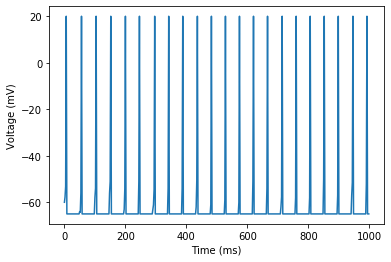

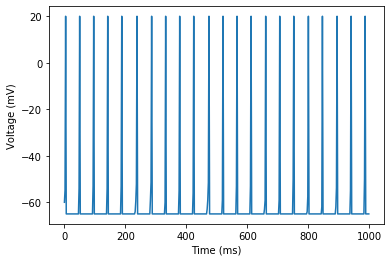

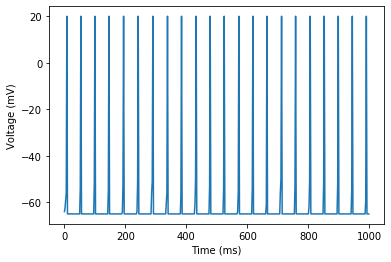

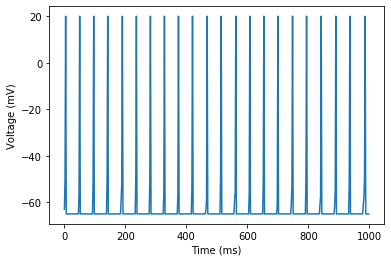

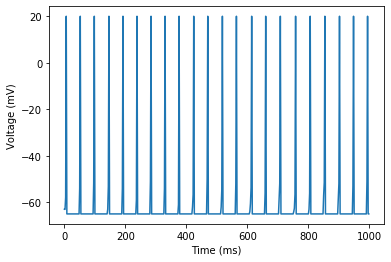

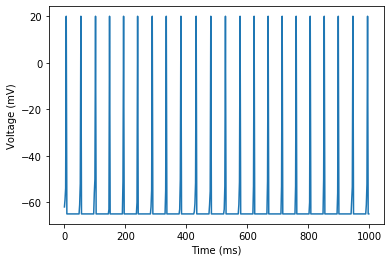

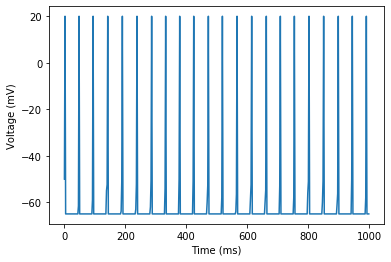

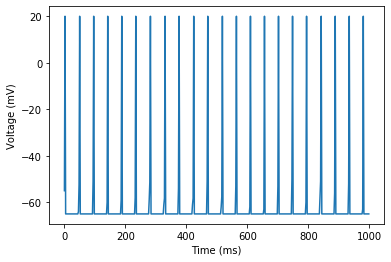

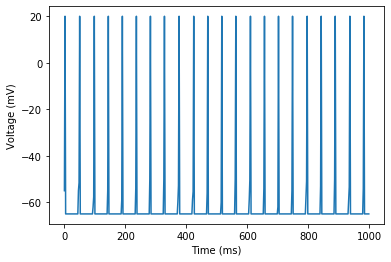

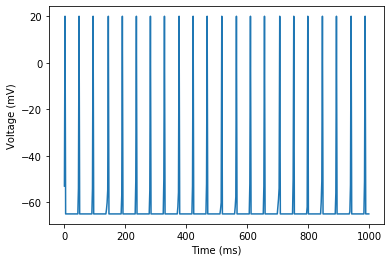

In [24]:
net.V_Plot(V_ctx, [0,10,20,30,40,50,60,70,80,90]) #Voltage_log, neuron_number

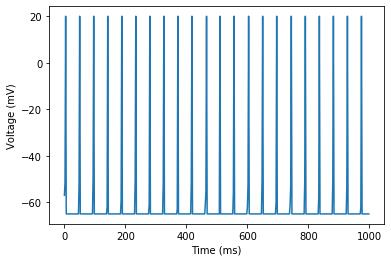

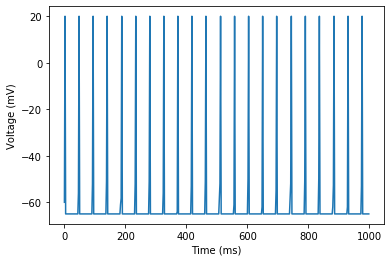

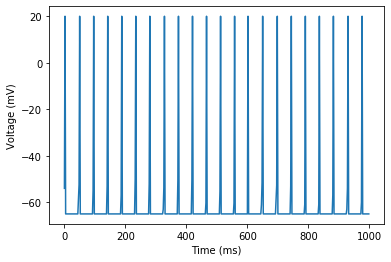

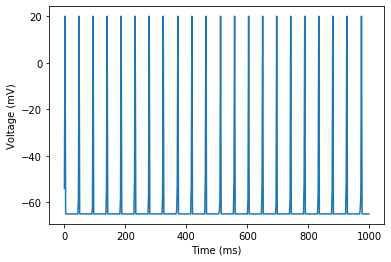

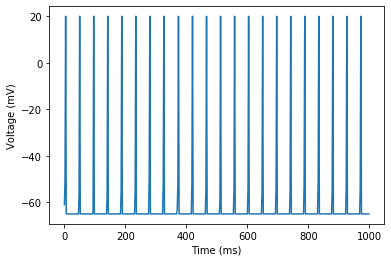

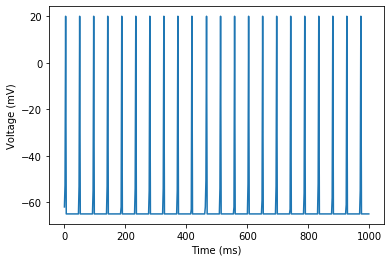

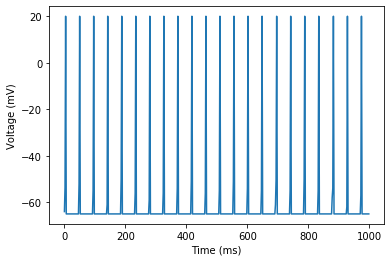

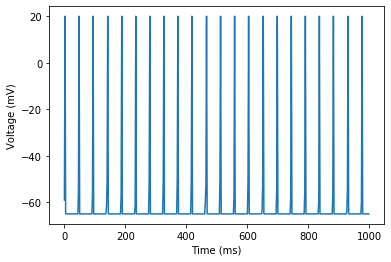

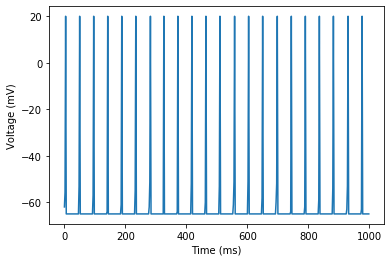

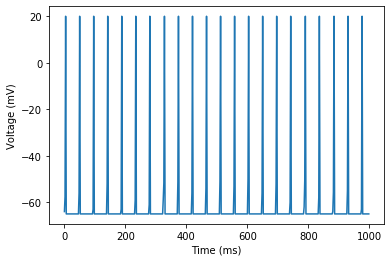

In [25]:
net.V_Plot(V_str, [0,10,20,30,40,50,60,70,80,90])

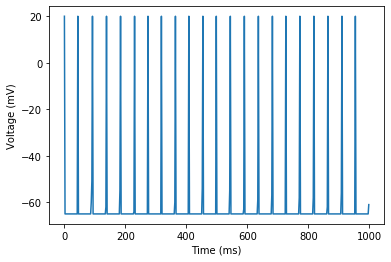

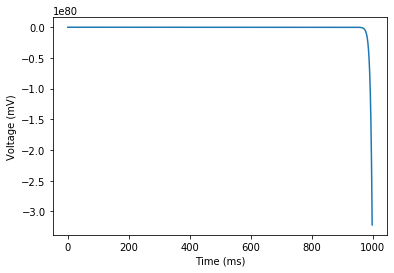

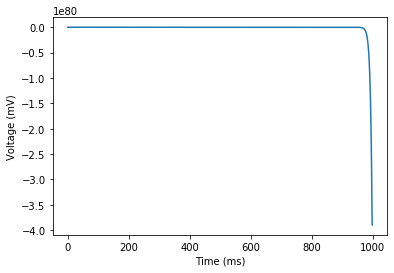

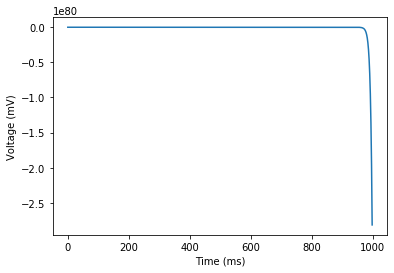

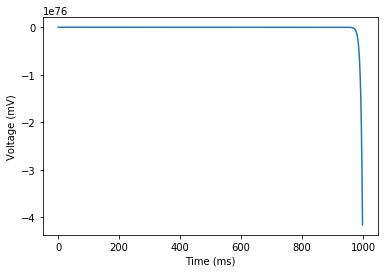

In [26]:
net.V_Plot(V_snr, [0,10,20,30,40])

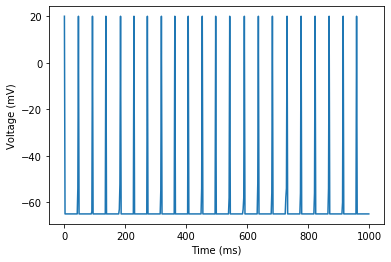

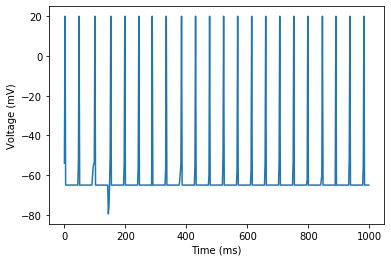

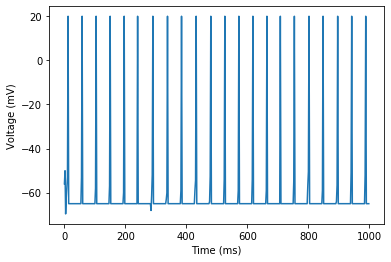

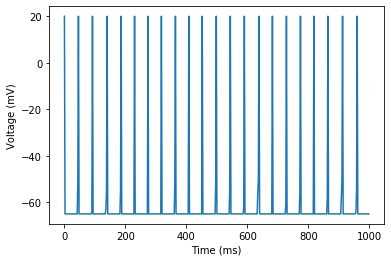

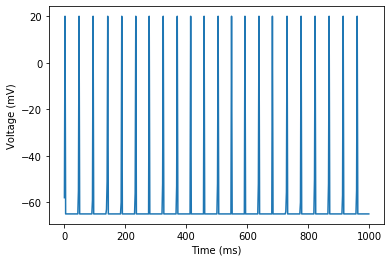

In [27]:
net.V_Plot(V_gpe, [0,10,20,30,40])